In [ ]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy import special
from tqdm import tqdm
from math import floor
import statsmodels.api as sm

In [ ]:
def gen():
    return int(np.random.random() * 10**6)

In [ ]:
def generator_uniform(n):
    return np.sort(np.random.uniform(-np.sqrt(3), np.sqrt(3), n))

def generator_normal(n):
    return np.sort(np.random.normal(0, 1, n))

def generator_exponential(n):
    return np.sort(stats.expon(scale=1, loc=-1).rvs(size=n, random_state=gen()))

# 1

In [ ]:
q = 0.95

In [ ]:
def get_weighted_elements(array, index):
    index_int = floor(index)
    index_piece = index - index_int

    if index_int == array.size - 1:
        return array[index_int]

    return array[index_int] * (1 - index_piece) + array[index_int + 1] * index_piece

def get_median_interval(sample, q):
    p_half = 0.5
    n = sample.size
    sample = np.sort(sample)
    quant = stats.norm.ppf((1 + q) / 2)
    assert(n * p_half * (1 - p_half) > 0)
    k_1, k_2 = n * p_half - np.sqrt(n * p_half * (1 - p_half)) * quant, n * p_half + np.sqrt(n * p_half * (1 - p_half)) * quant

    k_1, k_2 = max(0, k_1), min(n - 1, k_2)
    l = get_weighted_elements(sample, k_1)
    r = get_weighted_elements(sample, k_2)
    assert(l < r)
    return [l, r]

In [ ]:
def get_variance_interval(sample, q):
    n = sample.size
    var = np.var(sample, ddof=1)
    q1, q2 = stats.chi2.ppf((1 + q) / 2, n - 1), stats.chi2.ppf((1 - q) / 2, n - 1)
    return [
        var * (n - 1) / q1, var * (n - 1) / q2
    ]

def get_mad_interval(sample, q):
    median = np.quantile(sample, 0.5)
    sample_new = np.abs(sample - median)

    return get_median_interval(sample_new, q)

In [ ]:
def estimate_interval_prob(generator, get_interval, true_value, n=10**2, N=10**4):
    count_good = 0
    for _ in tqdm(range(N)):
        sample = generator(n)
        interval = get_interval(sample, q)

        count_good += int (interval[0] <= true_value <= interval[1])
    prob_interval = sm.stats.proportion_confint(abs(int(count_good)), N, alpha=0.05, method='binom_test')
    return np.array(prob_interval)

In [ ]:
estimate_interval_prob(generator_uniform, get_mad_interval, 1, n=100)

100%|██████████| 10000/10000 [00:02<00:00, 4866.90it/s]


6188 100


array([0.60920317, 0.6283037 ])

In [ ]:
estimate_variance_interval_prob_uniform = \
    lambda n : estimate_interval_prob(generator_uniform, get_variance_interval, 1, n = n)


estimate_variance_interval_prob_normal = \
    lambda n : estimate_interval_prob(generator_uniform, get_variance_interval, 1, n = n)


estimate_variance_interval_prob_exponential = \
    lambda n : estimate_interval_prob(generator_exponential, get_variance_interval, 1, n = n)


In [ ]:
estimate_mad_interval_prob_uniform = \
    lambda n : estimate_interval_prob(generator_uniform, get_mad_interval, 0.6742, n = n)


estimate_mad_interval_prob_normal = \
    lambda n : estimate_interval_prob(generator_uniform, get_mad_interval, 0.8662, n = n)


estimate_mad_interval_prob_exponential = \
    lambda n : estimate_interval_prob(generator_exponential, get_mad_interval, 0.4811, n = n)


In [ ]:
n_arange = [50, 100, 250]

data = np.array([
[estimate_variance_interval_prob_uniform(n) for n in n_arange],
[estimate_variance_interval_prob_normal(n) for n in n_arange],
[estimate_variance_interval_prob_exponential(n) for n in n_arange],

[estimate_mad_interval_prob_uniform(n) for n in n_arange],
[estimate_mad_interval_prob_normal(n) for n in n_arange],
[estimate_mad_interval_prob_exponential(n) for n in n_arange],
])

100%|██████████| 10000/10000 [00:09<00:00, 1055.73it/s]


In [ ]:
data[5].reshape((1, -1))[0]

array([0.78795843, 0.80380869, 0.78715831, 0.80300855, 0.78160792,
       0.79760859])

In [ ]:
data[0]

array([[0.99606656, 0.9981662 ],
       [0.99631549, 0.99832174],
       [0.9975001 , 0.99911926]])

In [ ]:
n_arange = np.repeat(n_arange, 2)

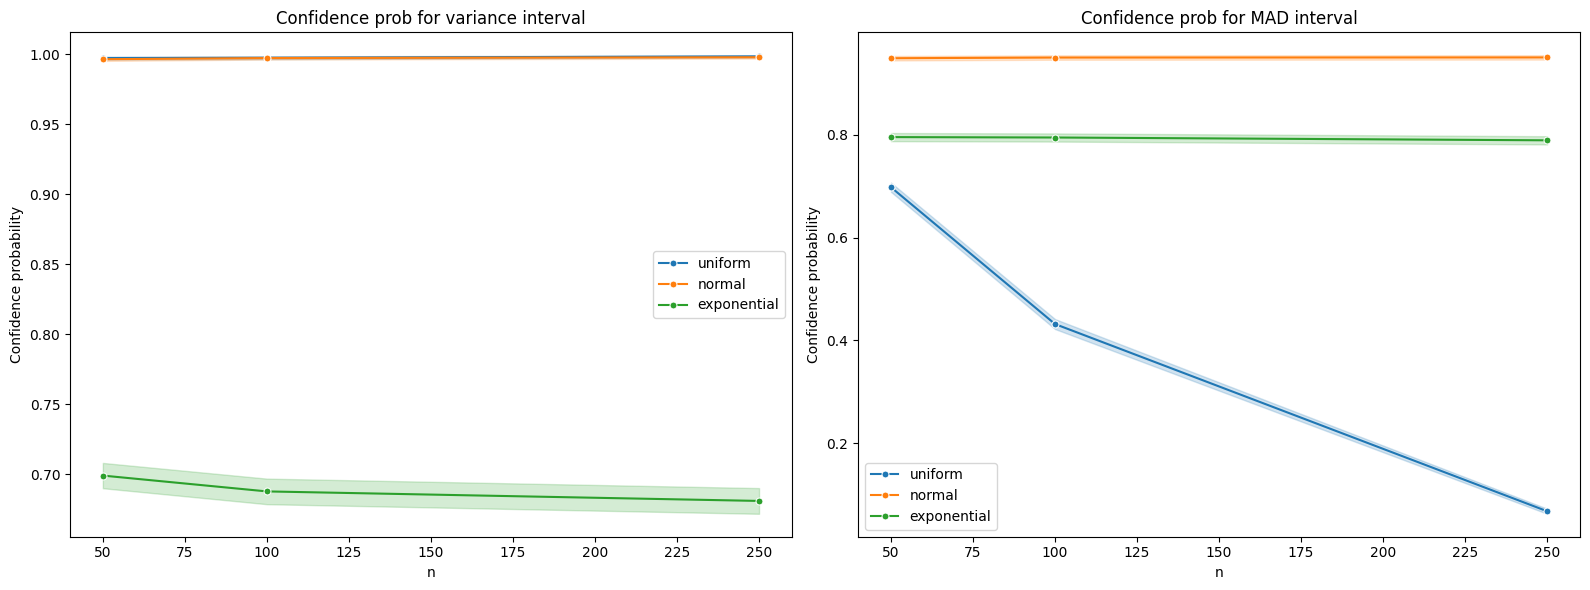

In [ ]:
data_1 = pd.DataFrame({'x': n_arange, 'y': data[0].reshape((1, -1))[0]})
data_2 = pd.DataFrame({'x': n_arange, 'y': data[1].reshape((1, -1))[0]})
data_3 = pd.DataFrame({'x': n_arange, 'y': data[2].reshape((1, -1))[0]})

data_4 = pd.DataFrame({'x': n_arange, 'y': data[3].reshape((1, -1))[0]})
data_5 = pd.DataFrame({'x': n_arange, 'y': data[4].reshape((1, -1))[0]})
data_6 = pd.DataFrame({'x': n_arange, 'y': data[5].reshape((1, -1))[0]})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data=data_1, x='x', y='y', marker='o', markersize=5, label='uniform', ax=axes[0])
sns.lineplot(data=data_2, x='x', y='y', marker='o', markersize=5, label='normal', ax=axes[0])
sns.lineplot(data=data_3, x='x', y='y', marker='o', markersize=5, label='exponential', ax=axes[0])
axes[0].set_title("Confidence prob for variance interval")
axes[0].set_xlabel("n")
axes[0].set_ylabel("Confidence probability")

sns.lineplot(data=data_4, x='x', y='y', marker='o', markersize=5, label='uniform', ax=axes[1])
sns.lineplot(data=data_5, x='x', y='y', marker='o', markersize=5, label='normal', ax=axes[1])
sns.lineplot(data=data_6, x='x', y='y', marker='o', markersize=5, label='exponential', ax=axes[1])
axes[1].set_title("Confidence prob for MAD interval")
axes[1].set_xlabel("n")
axes[1].set_ylabel("Confidence probability")

plt.tight_layout()
plt.show();

# 2